# Deploying the sentiment RNN predictor in SageMaker

## Imports

In [53]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sagemaker
import os
from sagemaker.tensorflow import TensorFlow
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

print('Done')

Done


## Loading the dataset stored locally

In [27]:
train = pd.read_csv('dataset.csv', sep=',')
train.head()

,selected_text,sentiment
0,have responded if were going,0
1,sooo sad,1
2,bullying me,1
3,leave me alone,1
4,sons of,1


## Converting the labels into categorical type
(because we'll use categorical_crossentropy loss)

In [28]:
labels = tf.keras.utils.to_categorical(train['sentiment'], 3, dtype="float32")

In [29]:
#Converting features into numpy array
X = np.array(train['selected_text'])

In [30]:
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [62]:
X

array(['have responded if were going', 'sooo sad', 'bullying me', ...,
       'yay good for both of you', 'but it was worth it',
       'all this flirting going on the atg smiles yay hugs'], dtype=object)

## Creating a session object and uploading data to S3

In [32]:
sage_maker_session = sagemaker.Session()

In [33]:
#This returns the complete s3 path of the data file.
prefix = 'tensorflow-sentiment-predictions' #The name of the S3 bucket previously created
dataset_input_path = sage_maker_session.upload_data('dataset.csv', key_prefix=prefix+'/dataset')

In [34]:
dataset_input_path

's3://sagemaker-us-east-1-274416698914/tensorflow-sentiment-predictions/dataset/dataset.csv'

### Double-checking if the S3 upload was done properly

In [35]:
#Reading the csv file from S3
dataset = pd.read_csv(dataset_input_path, sep=',')

In [36]:
dataset.head()

,selected_text,sentiment
0,have responded if were going,0
1,sooo sad,1
2,bullying me,1
3,leave me alone,1
4,sons of,1


### Transforming all feature values into string type (otherwise you'll get errors)

In [63]:
labels = dataset['sentiment'].values
features = dataset['selected_text'].values
X = []
for i in range(len(features)):
    X.append(str(features[i]))

## Building the train.py file and saving it into the JupyterLab home directory

In [45]:
%%writefile train.py
import argparse
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument('--epochs', type=int, default=40)
    parser.add_argument('--max_words', type=int, default=5000)
    parser.add_argument('--max_len', type=int, default=200)
    parser.add_argument('--gpu_count', type=int, default=os.environ['SM_NUM_GPUS'])

    # input data and model directories
    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])

    args, _ = parser.parse_known_args()
    
    epochs     = args.epochs
    max_words  = args.max_words
    max_len    = args.max_len
    gpu_count  = args.gpu_count
    model_dir  = args.model_dir
    training_dir   = args.train
    
    data = pd.read_csv(training_dir+'/dataset.csv',sep=',')

    labels = data['sentiment'].values
    labels = tf.keras.utils.to_categorical(labels, 3, dtype="float32")
    features = data['selected_text'].values
    X = []
    for i in range(len(features)):
        X.append(str(features[i]))
    
    #Tokenizing data and making them sequences
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X)
    sequences = tokenizer.texts_to_sequences(X)
    features = pad_sequences(sequences, maxlen=max_len)
    
    #Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(features,labels, random_state=0)
    print (len(X_train),len(X_test),len(y_train),len(y_test))

    # Building the model
    model = Sequential()
    model.add(layers.Embedding(max_words, 40, input_length=max_len))
    model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
    model.add(layers.Dense(3,activation='softmax'))
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test))
    
    #Validating model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('Model accuracy: ',test_acc)
    
    model_path = '{}/{}/001'.format(model_dir, 'tensorflow-sentiment-predictions')
    tf.saved_model.save(model, model_path)

Overwriting train.py


In [46]:
#Checking TF version - it must be > 2.0
tf_version = tf.__version__
tf_version

'2.1.0'

## Creating a training job on SageMaker
I'll use the previous train.py script that has all the required parameters to go through the RNN training.

In [47]:
role = sagemaker.get_execution_role()

In [48]:
model_dir = '/opt/ml/model'
tf_estimator = TensorFlow(entry_point='train.py', 
                          role=role,
                          model_dir=model_dir,
                          train_instance_count=1, 
                          train_instance_type='ml.p2.xlarge',
                          framework_version=tf_version, 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 5,
                          }
                         )
# IMPORTANT: Only use *ml.p2.xlarge* instance type because it's the one that the limit has been increased.

In [49]:
#Starting the training, calling the fit method and passing the training data path. 
#This creates a training job on SageMaker. 
tf_estimator.fit({'train': dataset_input_path})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-07 19:45:23 Starting - Starting the training job...
2020-10-07 19:45:25 Starting - Launching requested ML instances......
2020-10-07 19:46:45 Starting - Preparing the instances for training.........
2020-10-07 19:48:03 Downloading - Downloading input data...
2020-10-07 19:48:28 Training - Downloading the training image........2020-10-07 19:50:08,187 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-10-07 19:50:08,605 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "model_dir": "/opt/ml/model",
        "epochs": 5
    },
    "input_config_dir": "/opt/ml/input/config",
    "input_data_config": {
        "train": {
           

## Deploying the model to SageMaker

In [50]:
endpoint_name = 'tensorflow-sentiment-predictions'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
end_point = tf_estimator.deploy(initial_instance_count=1,instance_type='ml.p2.xlarge',endpoint_name=endpoint_name)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------------!

After several minutes your endpoint should be alive. To check if everything's ok, print its name:

In [51]:
print(end_point.endpoint)

tensorflow-sentiment-predictions2020-10-07-19-54-33


## Validating the model

In [67]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


In [68]:
X_test[:10]

['wish',
 'gosh today sucks',
 'tired and didn really have an exciting saturday oh well hope it better tomorrow',
 've been eating cheetos all morning',
 'haiiii sankq fineee ima js get checkup cos my rib hurts lol idk but shall be fine thanks',
 'congrats',
 'loved',
 'in weho they re are playing lot of brit',
 'oh only in my just joined twitter few days ago',
 'awww wish was there']

### Recreating the tokenizer

In [95]:
import pickle

def preprocess_texts(text):
    
    max_words = 5000
    max_len = 200

    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(X)
    sequences = tokenizer.texts_to_sequences(text)
    sequences = pad_sequences(sequences, maxlen=max_len)
    # saving tokenizer
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return sequences

In [96]:
test_text = preprocess_texts(X_test)

In [97]:
len(test_text)

6871

### Inferencing on test text

In [98]:
predictions = end_point.predict(test_text)

In [99]:
np.around(predictions['predictions'], decimals=0).argmax(axis=1)

array([2, 1, 2, ..., 1, 0, 0])

In [100]:
y_test

array([2, 1, 0, ..., 2, 0, 0])

### Plotting the confusion matrix
Notice that we've trained only for 5 epochs (and not 70) so the result won't the the same as in the previous notebook.
I did it for 5 epochs due to cost reasons

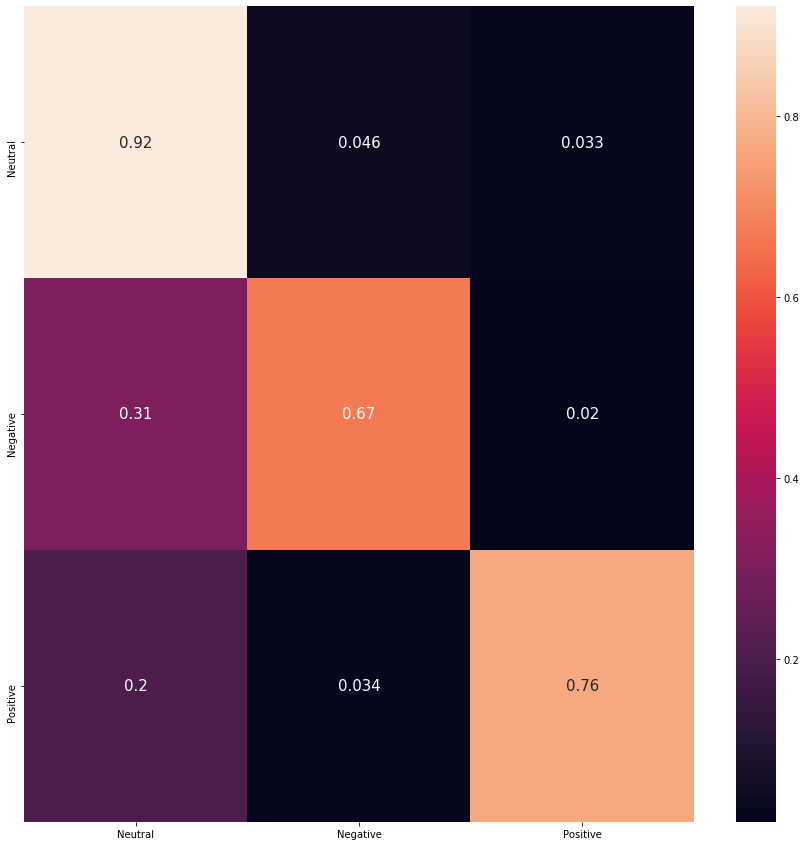

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
matrix = confusion_matrix(y_test, np.around(predictions['predictions'], decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [102]:
sentiment = ['Neutral','Negative','Positive']

### Testing on phrases that contain selected language

In [106]:
# loading tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=200)
test = end_point.predict(test)
sentiment[np.around(test['predictions'], decimals=0).argmax(axis=1)[0]]

'Positive'

In [107]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=200)
test = end_point.predict(test)
sentiment[np.around(test['predictions'], decimals=0).argmax(axis=1)[0]]

'Negative'

In [110]:
# Make sure to call end_point.delete_endpoint()to delete the model endpoint.
# After go ahead and delete any files uploaded by sagemaker from your s3 bucket.
end_point.delete_endpoint()

# We've reached the end of this notebook :)
If you find this helpful please drop your clap on Medium or wherever you found this how-to!